# STDSR23 - Assignment-01

> Karim Galliamov, @kgall739, B21-DS-01

# Quantile implementation

February 2023

## Assignment description

* Obtain the research paper titled ["A Survey of Approximate Quantile Computation on Large-Scale Data"](https://arxiv.org/pdf/2004.08255.pdf)

* Select and implement one of the methods discussed in the paper, following good coding style and with appropriate comments. Your algorithm can be based on `BasicQuantileAlgorithm` class. In that case, your main implementation is in the `compute_quantile` function.
* Prepare a report that includes
    * A detailed explanation of the selected algorithm
    * A listing of the pros and cons of the chosen algorithm
* Test your implementation. More on that below in section `Test`.
* Submit Jupyter Notebook *.ipynb* to the Moodle

Note: Code style, comments, and overall organization of the report will be
taken into account in the grading process.


## Abstract implementation

Can be used as a basic class for your implementation

In [1]:
import math
import time
import random
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

from typing import List
from tqdm import tqdm, tqdm_notebook
from math import comb, ceil, floor
from bisect import bisect_left
from sys import getsizeof

In [2]:
class BasicQuantileAlgorithm:
    """
    Abstract class for quantile computing algorithm
    """
    
    def __init__(self) -> None:
        """
        Initializer for algorithm
        """
    
    def compute_quantile(self, q) -> float:
        """
        Implementation of some quantile algorithm
        """
        raise NotImplementedError('compute_quantile is not implemented')
    
    def compute(self, q) -> float:
        assert 0.0 <= q <= 1.0, f"q should be in [0;1]. Got {q}"
        """
        Compute the q-th quantile
        
        Hides implementation of _compute_quantile. 
        
        :param q: Quantile to compute, which must be between 0 and 1 inclusive
        :return: q-th quantile
        """
        return self.compute_quantile(q)
    
    # NOTE: multi_compute is just a basic function
    # for computing multiple quantile with one function call. 
    # This can be modified, so that multiple quantiles
    # calculation become efficient. 
    def multi_compute(self, qs) -> List[float]:
        """
        Compute multiple q-th quantiles
        
        :param qs: list of quantiles to compute, 
            all should be between 0 and 1 inclusive
        :return: list of computed quantiles
        """
        return [self.compute(q) for q in qs]
    
    def __sizeof__(self):
        raise NotImplementedError('sizeof is not implemented')

This is just an example of the algorithm implementation.

In [3]:
class NumpyQuantileAlgorithm(BasicQuantileAlgorithm):
    """
    Example of quantile algorithm
    
    This algorithm implementation is 
    based on the numpy.quantile. 
    """
    def __init__(self):
        """
        Initializer of the class. 
        
        It initializes self.data with empty list
        """
        self.data = []
    
    def add_item(self, item):
        """
        Adds an item to the existing data
        """
        self.data.append(item)
    
    def add_multiple_items(self, items):
        """
        Adds multiple items to the existing data
        """
        self.data += items
    
    def compute_quantile(self, q) -> float:
        """
        Compute the q-th quantile
        
        :param q: Quantile to compute, which must be between 0 and 1 inclusive
        :return: q-th quantile
        """
        return np.quantile(self.data, q)
    
    # NOTE: Here, for multi_compute we
    # can just call the same function
    # compute_quantile, because it could
    # take a vector of multiple quantiles.
    # This is more efficient, than basic 
    # function call, because of the 
    # vectorized implementation.
    def multi_compute(self, qs) -> List[float]:
        """
        Compute multiple q-th quantiles
        
        :param qs: list of quantiles to compute, 
            all should be between 0 and 1 inclusive
        :return: list of computed quantiles
        """
        return list(self.compute_quantile(qs))
    
    def __sizeof__(self):
        return getsizeof(self.data)
    
    def __str__(self):
        return "Basic Numpy Algorithm"

Greenwald-Khanna 01 [Algorithm](http://infolab.stanford.edu/~datar/courses/cs361a/papers/quantiles.pdf)

In [4]:
class GK01Algorithm(BasicQuantileAlgorithm):

    def __init__(self, eps: float):
        """
        :param eps: Desired approximation error
        """
        super().__init__()
        self.eps = eps
        self.S = [] # Summary
        self.s = 0 # Summary size
        self.n = 0 # Number of the processed input elements

    def add_item(self, item):
        """
        Adds an item to the existing Summary
        """
        if self.n % (1 // (2 * self.eps)) == 0:
            self._compress()
        self._insert(item)
        self.n += 1

    def add_multiple_items(self, items):
        """
        Adds multiple items to the existing Summary
        """
        for item in items:
            self.add_item(item)

    def compute_quantile(self, q) -> float:
        """
        Find such element in the Summary that its rank is in the epsilon error margin
        :param q: Quantile to be computed
        :return: self.eps - approximate q quantile of the original data stream
        """
        if q == 0:
            return self.S[0]['v']
        if q == 1:
            return self.S[-1]['v']
        r = ceil(q * self.n)
        r_min = 0
        for i in range(self.s):
            r_min += self.S[i]['g']
            r_max = r_min + self.S[i]['delta']
            if r - r_min <= self.eps * self.n and r_max - r <= self.eps * self.n:
                return self.S[i]['v']
        raise IndexError('Could not find quantile')

    def _compress(self):
        """
        Merge the buffers together if possible under epsilon precision constraint
        :return: None
        """
        for i in range(self.s - 2, 0, -1):
            while i < self.s - 1:
                if self.S[i]['delta'] >= self.S[i + 1]['delta'] and \
                        self.S[i]['g'] + self.S[i + 1]['g'] + self.S[i + 1]['delta'] < 2 * self.eps * self.n:
                    self._delete(i)
                else:
                    break

    def _insert(self, item):
        """
        Find the smallest i such that v_i-1 <= item < v_i
        and insert (v, 1, floor(2 * eps * n)) between t_i-1 and t_i,
        increment s; if the new max / min has been found, insert (v, 1, 0)
        :param item: Observed value
        :return: None
        """
        ind = bisect_left(self.S, item, key=lambda t: t['v'])
        delta = floor(2 * self.eps * self.n) if 0 < ind < self.s - 1 else 0
        self.S.insert(ind, {'v': item, 'g': 1, 'delta': delta})
        self.s += 1

    def _delete(self, ind: int):
        """
        Replace (v_i, g_i, delta_i) and (v_i+1, g_i+1, delta_i+1)
        with (v_i+1, g_i + g_i+1, delta_i+1) and decrement s
        :param ind: Index of a tuple to be deleted
        :return: None
        """
        self.S[ind + 1]['g'] += self.S[ind]['g']
        del self.S[ind]
        self.s -= 1

    def multi_compute(self, qs) -> List[float]:
        """
        :param qs: List of quantiles to compute
        """
        qs = np.asarray(qs)
        ans = np.empty((len(qs)))
        r = np.ceil(qs * self.n)
        r_min = np.zeros((len(qs)), dtype=int)
        for i in range(self.s):
            r_min += self.S[i]['g']
            r_max = r_min + self.S[i]['delta']
            # Select v_i as andwer for all quantiles that fall in the epsilon error margin of this element
            ans[np.logical_and(r - r_min <= self.eps * self.n, r_max - r <= self.eps * self.n)] = self.S[i]['v']
        # 0 and 1 quantiles are always at the first and the last position at the Summary, by construction
        ans[qs == 0] = self.S[0]['v']
        ans[qs == 1] = self.S[-1]['v']
        return list(ans)

    def __sizeof__(self):
        # Return the size of the Summary holding the data values
        return getsizeof(self.S)

    def __str__(self):
        return f"GK-01 Algorithm with eps = {self.eps}"

> YOUR REPORT ABOUT THE ALGORITHM

> Add comparison of the time and space consumption (with numpy algorithm). Plot them depending on the sample size or time if your algorithm is for time-series quantile calculation.

## Report about algorithm

###  Algorithm's main idea

To obtain sub-linear space complexity, Greenwald and Khanna proposed the Summary Data Structure. By its means one can 
use a subset of the original sample values to represent the whole sample (more specifically, its quantiles) with the predefined error $\epsilon$: for any rank $r \in [0;1]$ the algorithm returns such value that its actual rank $r_{true} \in [r - \epsilon N; r + \epsilon N]$, where $N$ is the size of the input sequence.

### Summary DS

Summary $S$ contains $s$ tuples of 3 elements each: ($v_i$, $g_i$, $\delta_i$), where $i$ is from $[0; s-1]$

Tuples in Summary are sorted by element $v_i$, which is some element from the input sequence.

$g_i$ is defined as $r_{min}(v_i) - r_{min}(v_{i-1})$

$\delta_i$ is defined as $r_{max}(v_i) - r_{min}(v_i)$

where $r_{min}(v)$ and $r_{max}(v)$ give the lower and upper bound on the rank of $v$ in the so far seen data.

One can see that $r_{min}(v_i) = \sum_{j \leq i}^{} g_j$, $r_{max}(v_i) = \delta_i + \sum_{j \leq i}^{} g_j$ and $\sum_{i} g_i = n$ where $n$ is the number of seen input elements.    

A tuple $i$ is called full if $g_i + \delta_i = \left \lfloor{2 \epsilon n}\right \rfloor$. A tuple capacity is the maximum number of items counted by $g_i$ until the tuple becomes full.

$\delta$'s are split into *bands* : intervals between $0, \frac{1}{2}2\epsilon n, ..., \frac{2^i - 1}{2^i}2\epsilon n,..., 2\epsilon n$. These intervals denote capacities of a tuple: $2 \epsilon n, \epsilon n, ... , \frac{1}{2^i} \epsilon n, ..., 1$
        
### Operations on Summary DS
        
    QUANTILE
Given quantile $p$ from $[0;1]$ return $\epsilon$-approximate quantile for the input data: find $i$ such that for $r = \left \lceil{p * n}\right \rceil$ the following holds:

$r - r_{min}(v_i) \leq n * \epsilon$ and $r_{max}(v_i) - r \leq n * \epsilon$, return $v_i$ as the answer.


    INSERT
Given a new input element $v$ insert into the Summary tuple $(v, 1, \left \lfloor{2 \epsilon n}\right \rfloor)$ between tuples with $v_{i-1}$ and $v_i$ so that $v_{i-1} \leq v < v_i$. If $v$ is the new maximum or minimum among $v_i$, insert the tuple $(v, 1, 0)$.
    
    DELETE
Given an element $v_i$ to remove from the Summary, delete $i$ th tuple from the list and set $ g_{i+1} := g_{i+1} + g_i$. The increase of $g_{i+1}$ is done for conditions on $r_{min}$ and $r_{max}$ to hold: $r_{min}(v_{i+1}) = \sum_{j \leq i + 1}^{} g_j$, so after $g_i$ is deleted, $g_{i+1}$ has to increase exaclty by this amount.
       
    COMPRESS
Go over the tuples in Summary from largest $v_i$ to smallest (excluding the endpoints), trying to merge a tuple with its descendants (DELETE the lower tuples). The tuple, produced by merging, must not be full: to merge tuple $i$ into tuple $i+1$ one has to check that $\delta_i \geq \delta_{i+1} $, i.e. $band(\delta_{i}) \leq band(\delta_{i+1})$, and that $g_i^* + g_{i+1} + \delta_{i+1} < 2 \epsilon n$, where $g_i^*$ is the sum of $g$'s of $i$th tuple and all its descendants. 

Authors claim that if COMPRESS is done in such a way, the merged tuples do not change their *band*s and the $\epsilon$-approximation error is not exceeded when estimating quantiles.
    
### Algorithm pros:

* Sublinear memory consumption: at any moment of runtime the amount of tuples in S is not greater than $\frac{11}{2 \epsilon} log(2 \epsilon N)$, which is $O(\frac{1}{\epsilon} log(\epsilon N)$ of occupied memory
* Does not require knowledge on the sample size in advance
* QUANTILE operation does not influence the state of the Summary and can be called anytime during execution
        
### Algorithm cons:
        
* Works slower than linear-memory algorithms
* Can only approximate quantiles over all seen data      

In [5]:
def test_algorithm(algorithm, sample, q: float = 0.5, log=True):
    s_t = time.time()
    algorithm.add_multiple_items(sample)
    ans = algorithm.compute(q)
    e_t = time.time()
    if log:
        print(algorithm)
        print(f"Sample size {len(sample)}")
        print(f"Time taken: {e_t - s_t} seconds")
        print(f"Memory occupied: {getsizeof(algorithm)} bytes")
    return ans, e_t - s_t, getsizeof(algorithm)

In [6]:
eps = 0.01
N = np.linspace(10 ** 2, 4 * 10 ** 6, 25, dtype=int)

numpy_memory_taken = []
GK01_memory_taken = []

numpy_time_taken = []
GK01_time_taken = []

for n in tqdm(N):
    lst = list(range(n))
    random.shuffle(lst)
    
    np_a = NumpyQuantileAlgorithm()
    GK01 = GK01Algorithm(eps)
    
    np_ans, np_time, np_mem = test_algorithm(np_a, lst, log=False)
    gk_ans, gk_time, gk_mem = test_algorithm(GK01, lst, log=False)
    numpy_memory_taken.append(np_mem)
    GK01_memory_taken.append(gk_mem)
    
    numpy_time_taken.append(np_time)
    GK01_time_taken.append(gk_time)

100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [05:45<00:00, 13.82s/it]


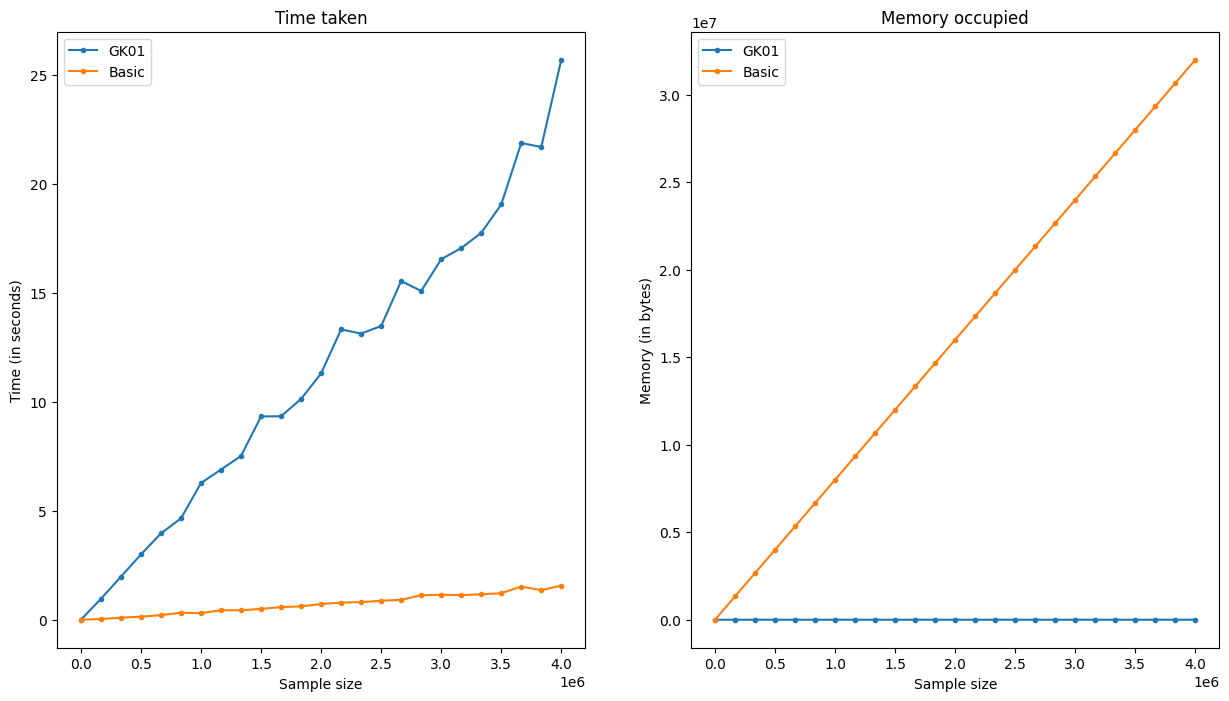

In [7]:
plt.figure(figsize=(15,8))

plt.subplot(1, 2, 1)
plt.plot(N, GK01_time_taken, marker='.', label='GK01')
plt.plot(N, numpy_time_taken, marker='.', label='Basic')
plt.legend(loc="best")
plt.xlabel('Sample size')
plt.ylabel('Time (in seconds)')
plt.title('Time taken')

plt.subplot(1, 2, 2)
plt.plot(N, GK01_memory_taken, marker='.', label='GK01')
plt.plot(N, numpy_memory_taken, marker='.', label='Basic')
plt.legend(loc="best")
plt.xlabel('Sample size')
plt.ylabel('Memory (in bytes)')
plt.title('Memory occupied')

plt.show()

As one can see from the graphs, GK-01 works much slower than the basic algorithm, but consumes almost constant space (relative to the same basic algorithm)

## Test

Here you need to show that your algorithm is working properly.
1. Take `normal` distribution. Show, that with increase in sample size, quantiles calculated with your algorithms are become very close to the `inverse cdf` of the distribution. 

2. Perform the same experiment with any other continuous distribution (exponential, logistic, etc.)

In [8]:
eps = 0.0001
P = np.linspace(eps, 1.0 - eps, 200)
N_range = list(np.logspace(2, 7, 6, dtype=int))


def check_convergence(distribution):
    quantiles = dict()
    for N in tqdm(N_range):
        gk = GK01Algorithm(eps=eps)
        gk.add_multiple_items(distribution.rvs(size=N))
        quantiles[N] = gk.multi_compute(P)

    plt.figure(figsize=(15,8))

    for N in range(2, 7 + 1):
        plt.subplot(2, 3, N - 2 + 1)
        inverse_cdf = distribution.ppf(P)
        plt.plot(P, inverse_cdf, linewidth=1)
        plt.plot(P, quantiles[10 ** N], linewidth=1)
        plt.title(f'10 ^ {N} samples')

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:35<00:00, 25.90s/it]


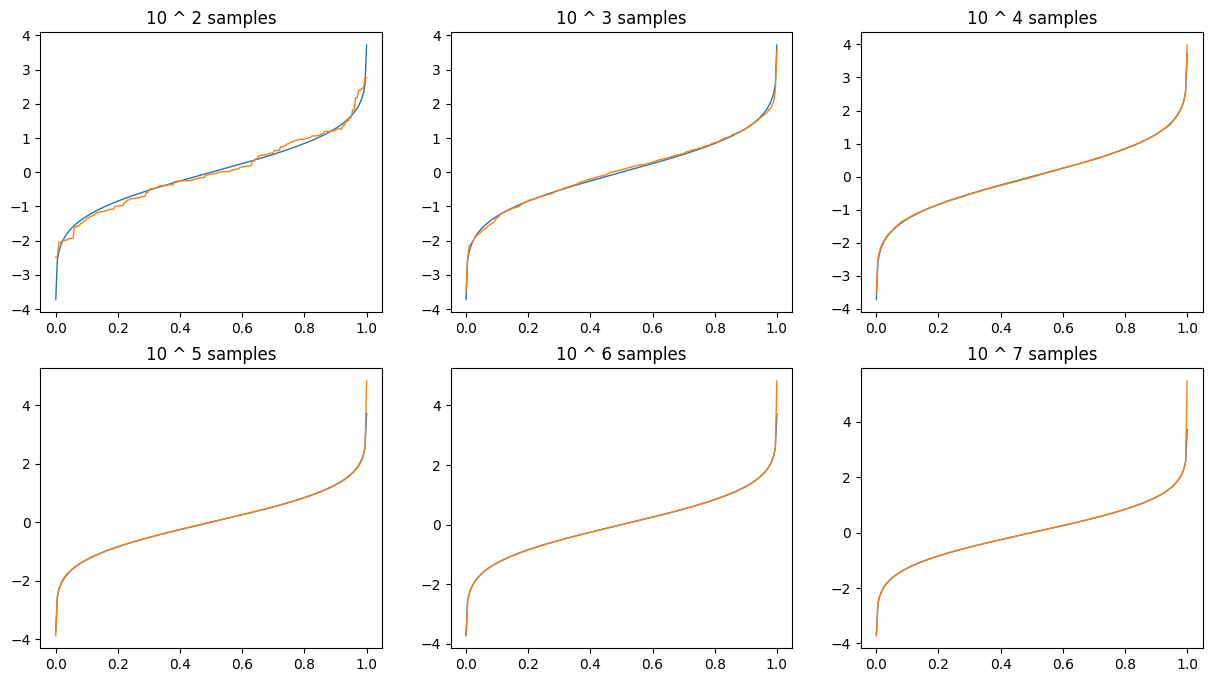

In [9]:
check_convergence(stats.norm(0, 1))

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:39<00:00, 26.55s/it]


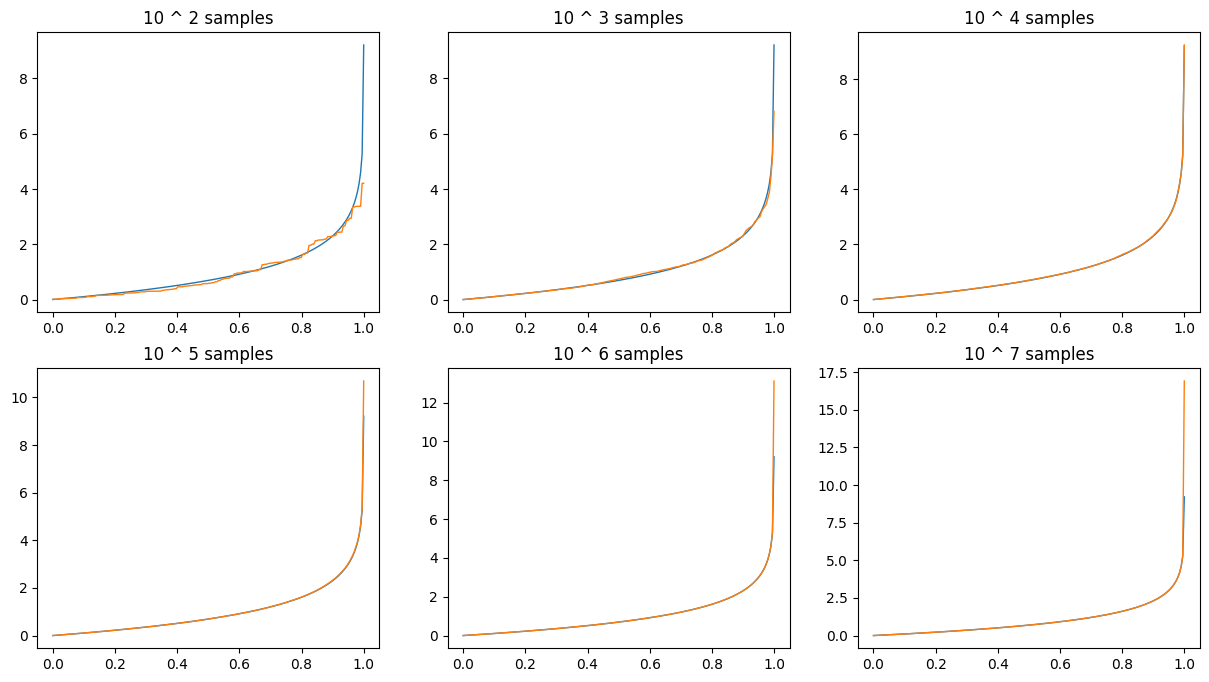

In [10]:
check_convergence(stats.expon)

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:38<00:00, 26.49s/it]


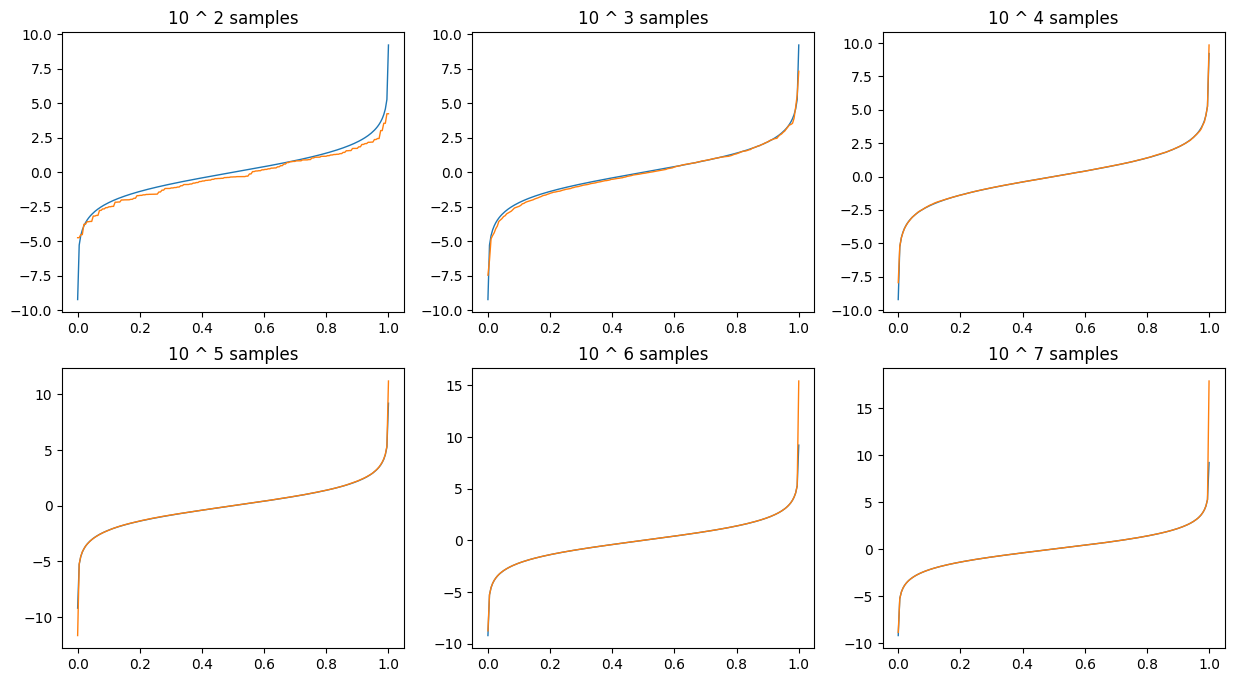

In [11]:
check_convergence(stats.logistic())

Perform an experiment that shows the main purpose of the algorithm. 

For example, some algorithms are created especially for time series data, so you should show that your algorithm is working in time series environment properly.

In [12]:
lst = list(np.random.normal(size = 10 ** 7))

np_a = NumpyQuantileAlgorithm()
GK01 = GK01Algorithm(0.001)

q = 0.75
print(f"Sample size = {len(lst)}\n")
np_ans, _, _ = test_algorithm(np_a, lst, q)
print()
gk_ans, _, _ = test_algorithm(GK01, lst, q)

Sample size = 10000000

Basic Numpy Algorithm
Sample size 10000000
Time taken: 1.0770995616912842 seconds
Memory occupied: 80000072 bytes

GK-01 Algorithm with eps = 0.001
Sample size 10000000
Time taken: 70.20550537109375 seconds
Memory occupied: 11720 bytes


In [13]:
GK01 = GK01Algorithm(0.001)
GK01.add_multiple_items(lst)
gk_ans_1 = GK01.compute(q)

GK01 = GK01Algorithm(0.001)
GK01.add_multiple_items(lst)
gk_ans_2 = GK01.compute(q)

print(gk_ans_1 == gk_ans_2)

True


As one can see, GK01 consumed orders of magnitude less space, and did not request prior knowledge of the sample size N

The algorithm is determenistic meaning that it produces the same result for runs with the fixed data and quantile